## Qual a vazão de saída do reservatório a cada momento? 

In [1]:
from pathlib import Path
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('future.no_silent_downcasting', True)

In [2]:
data_path = Path("../data/preprocessed_data/water_consumption_cleaned_0.parquet")
df = pd.read_parquet(data_path)
df.head()

,timestamp,flow_in_(l/s),reservoir_level_(%),pressure_(mca),gmb_1_is_on,gmb_2_is_on
0,2023-03-17 11:27:06,68.59,29.86,38.20,0,1
1,2023-03-17 12:28:56,66.05,35.86,38.20,0,1
2,2023-03-17 12:31:26,65.64,36.16,38.06,0,1
3,2023-03-17 12:33:56,65.64,36.50,38.03,0,1
4,2023-03-17 12:36:26,65.64,36.80,38.17,0,1


In [3]:
df['reservoir_level_(%)'] = df['reservoir_level_(%)'].replace(0.0, pd.NA).ffill().infer_objects(copy=False)
original_zero_mask = df['reservoir_level_(%)'] == 0.0
RESERVOIR_TOTAL_CAPACITY = 1_000_000
df["reservoir_level_liters"] = df["reservoir_level_(%)"] * RESERVOIR_TOTAL_CAPACITY / 100
df["time_passed_seconds"] = df["timestamp"].diff().dt.total_seconds()
df["liters_should_have_entered"] = df["time_passed_seconds"] * df["flow_in_(l/s)"]
df["liters_entered"] = df["reservoir_level_liters"].diff()

for idx in df[original_zero_mask].index:
    post_index = idx + 1
    if post_index < len(df):
        level_difference = df.loc[post_index, "liters_entered"] - df.loc[post_index, "liters_should_have_entered"]
        
        # Fix liters entered for the zero value
        df.loc[idx, "liters_entered"] = level_difference
        df.loc[idx, "liters_should_have_entered"] = level_difference
        df.loc[post_index, "liters_entered"] -= level_difference
        
        # Update flow_in_(l/s)
        df.loc[idx, "flow_in_(l/s)"] = df.loc[idx, "liters_entered"] / df.loc[idx, "time_passed_seconds"]
        
        # Update reservoir levels
        df.loc[idx, "reservoir_level_liters"] += level_difference
        df.loc[idx, "reservoir_level_(%)"] = df.loc[idx, "reservoir_level_liters"] / RESERVOIR_TOTAL_CAPACITY * 100


problematic_indexes = df["liters_should_have_entered"] < df["liters_entered"]        
for le in df[problematic_indexes].index:
    df.loc[le, "liters_should_have_entered"] = df.loc[le, "time_passed_seconds"] * (df.loc[le, "liters_entered"]/df.loc[le, "time_passed_seconds"])
    df.loc[le, "flow_in_(l/s)"] = df.loc[le, "liters_entered"] / df.loc[le, "time_passed_seconds"]
        
df["liters_out"] = df["liters_should_have_entered"] - df["liters_entered"]
df["flow_out_(l/s)"] = df["liters_out"] / df["time_passed_seconds"]
df = df.round(2).reset_index().rename(columns={"index": "id"})
df.head(100)

,id,timestamp,flow_in_(l/s),reservoir_level_(%),pressure_(mca),gmb_1_is_on,gmb_2_is_on,reservoir_level_liters,time_passed_seconds,liters_should_have_entered,liters_entered,liters_out,flow_out_(l/s)
0,0,2023-03-17 11:27:06,68.59,29.86,38.20,0,1,298600.0,NaN,NaN,NaN,NaN,NaN
1,1,2023-03-17 12:28:56,66.05,35.86,38.20,0,1,358600.0,3710.0,245045.50,60000.0,185045.50,49.88
2,2,2023-03-17 12:31:26,65.64,36.16,38.06,0,1,361600.0,150.0,9846.00,3000.0,6846.00,45.64
3,3,2023-03-17 12:33:56,65.64,36.50,38.03,0,1,365000.0,150.0,9846.00,3400.0,6446.00,42.97
4,4,2023-03-17 12:36:26,65.64,36.80,38.17,0,1,368000.0,150.0,9846.00,3000.0,6846.00,45.64
5,5,2023-03-17 12:38:56,65.24,36.80,38.17,0,1,368000.0,150.0,9786.00,0.0,9786.00,65.24
6,6,2023-03-17 12:41:26,66.46,37.10,38.03,0,1,371000.0,150.0,9969.00,3000.0,6969.00,46.46
7,7,2023-03-17 12:43:56,66.88,37.46,38.10,0,1,374600.0,150.0,10032.00,3600.0,6432.00,42.88
8,8,2023-03-17 12:50:28,66.05,38.06,38.10,0,1,380600.0,392.0,25891.60,6000.0,19891.60,50.74
9,9,2023-03-17 12:52:58,66.05,38.36,38.00,0,1,383600.0,150.0,9907.50,3000.0,6907.50,46.05


In [4]:
df.to_parquet("../data/curated_data/water_consumption_curated_1.parquet")

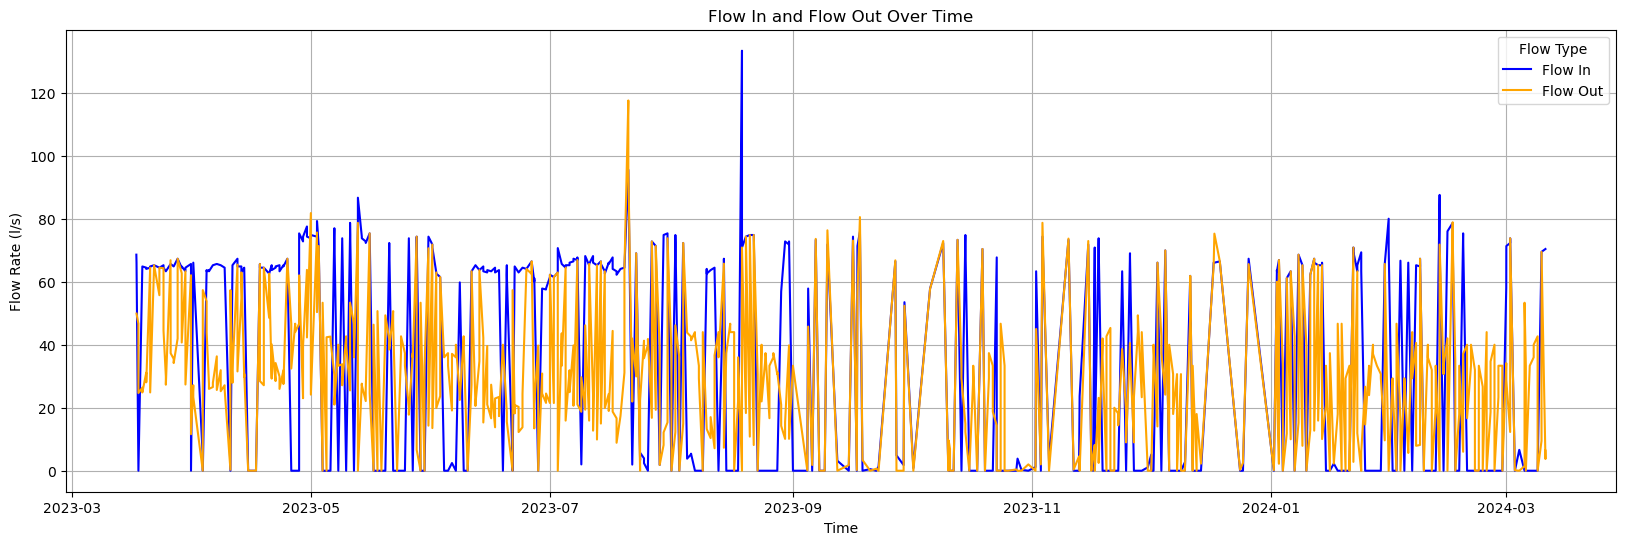

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df.copy()
df_filtered = df_filtered.groupby(df_filtered['timestamp'].dt.date).head(2).reset_index(drop=True)

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_filtered, x='timestamp', y='flow_in_(l/s)', label='Flow In', color='blue')
sns.lineplot(data=df_filtered, x='timestamp', y='flow_out_(l/s)', label='Flow Out', color='orange')
plt.title('Flow In and Flow Out Over Time')
plt.xlabel('Time')
plt.ylabel('Flow Rate (l/s)')
plt.legend(title='Flow Type')
plt.grid(True)
plt.show()